## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
from scipy import signal
plt.style.use('seaborn-colorblind')
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

## Création des données pour la classification

Ci dessous les leviers sur lesquels jouer pour réaliser une classification. On entre le nom du jeu de données de train, de test. on choisit la taille n du filtre pour smooth les enregistrements, la longueur de la fenêtre sur laquelle on construit nos features pour les données de train et de test. liste_labels contient dans l'ordre les labels des classes par lesquelles on passe dans l'enregistrement de test, par exemple [0, 1, 0] si je suis assis puis je marche puis je suis assis. Dans liste_transition, on note les numeros des points de l'enregistrement où l'on switch d'une activité à l'autre, par exemple, si j'ai enregistré 22000 points et que j'ai changé d'activité au 8000ème point puis au 14000ème point, je prend [8000, 14000].


Il reste ensuite à choisir des features qui expliquent bien les données, pour l'instant on utilise seulement la variance sur une fenêtre et l'écart max à la valeur médiane sur la fenêtre pour l'accélération sur l'axe vertical et pour l'accélération dans le plan horizontal (norme des deux coordonnées dans ce plan). Cela fait quatre variables explicatives. 

In [2]:
def create_train(train_name, window_length, recouvrement, n, liste_labels, liste_transitions):
    def cree_labels(features, liste_transitions, liste_labels):
        #il faut bien avoir assez de label sinon on renvoie une erreur
        #liste_transitions.append(len(features))
        labels = np.zeros(len(features))
        past_index = 0
        current_index = 0
        for k in range(len(liste_transitions)):
            current_index = liste_transitions[k]
            labels[past_index : current_index] = liste_labels[k]
            past_index = current_index
        labels[liste_transitions[-1] : len(features)] = liste_labels[len(liste_transitions)]
        return labels
    data = pd.read_csv(train_name, engine = 'python')
    data = data.dropna()
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    liste_theta_z = []
    liste_theta_y = []
    
    labels = cree_labels(fdata, liste_transitions, liste_labels).astype(int)
    labels_idee = []
    bound = 0
    while int(bound + (1 - recouvrement) * window_length) < arrX.shape[0]:
        bound = int(bound + (1 - recouvrement) * window_length)
        labels_idee.append(np.argmax(np.bincount(np.array(labels[bound : bound + window_length]))))

        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[bound : bound + window_length].mean()
        yg = arrY[bound : bound + window_length].mean()
        zg = arrZ[bound : bound + window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))
        
        liste_theta_z.append(theta_z)

        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))
        
        liste_theta_y.append(theta_y)

        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[bound : bound + window_length], filteredY[bound : bound + window_length], filteredZ[bound : bound + window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    train_features = [[], [], [], [], [], [], [], [], [], []]
    for k in range(len(liste_windows)):
        train_features[0].append(np.var(liste_windows[k][0, :]))
        train_features[1].append(np.var(liste_windows[k][1, :]))
        train_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        train_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
        train_features[4].append(np.mean((liste_windows[k][0, :])))
        train_features[5].append(np.mean((liste_windows[k][1, :])))
        train_features[6].append(np.sqrt(np.mean(np.square(liste_windows[k][0, :]))))
        train_features[7].append(np.sqrt(np.mean(np.square(liste_windows[k][1, :]))))
    train_features[8] = liste_theta_z
    train_features[9] = liste_theta_y

    train_features = np.transpose(np.array(train_features))
    train_features = train_features[ : -1, :]
    labels_idee = labels_idee[ : -1]
    return train_features, labels_idee

In [3]:
def create_test(test_name, window_length, recouvrement, n):
    data = pd.read_csv(test_name, engine = 'python')
    data = data.dropna()
    filtre = np.ones(n)
    # Il faudra trouver un filtre correct
    filtre = np.array(filtre).reshape(len(filtre), 1)/len(filtre)
    filteredX = signal.convolve(data.get(['x']), filtre)
    filteredY = signal.convolve(data.get(['y']), filtre)
    filteredZ = signal.convolve(data.get(['z']), filtre)
    fdata = pd.DataFrame()
    fdata['X'] = filteredX[n : - n, 0]
    fdata['Y'] = filteredY[n : - n, 0]
    fdata['Z'] = filteredZ[n : - n, 0]
    #fdata.plot()
    arrX = np.array(data.get(['x']))
    arrY = np.array(data.get(['y']))
    arrZ = np.array(data.get(['z']))
    liste_windows = []
    liste_theta_z = []
    liste_theta_y = []
    bound = 0
    while int(bound + (1 - recouvrement) * window_length) < arrX.shape[0]:
        bound = int(bound + (1 - recouvrement) * window_length)
        # Recherche de l'accélération de la gravité sur la première seconde
        xg = arrX[bound : bound + window_length].mean()
        yg = arrY[bound : bound + window_length].mean()
        zg = arrZ[bound : bound + window_length].mean()
        G = [xg, yg, zg]
        G_objectif = [0, 0, - 9.8]
        # Il faut faire deux rotations
        # rotation autour de l'axe des ordonnées
        #On cherche l'argument dans xoy du projeté de G
        theta_z = cmath.phase(complex(G[0], G[1]))

        liste_theta_z.append(theta_z)

        rot_mat_z = [[math.cos(theta_z), - math.sin(theta_z), 0], [math.sin(theta_z), math.cos(theta_z), 0], [0, 0, 1]]
        G_rot = np.dot(G, rot_mat_z)
        # rotation autour de l'axe des abscisses

        theta_y = cmath.phase(complex(G_rot[0], G_rot[2]))

        liste_theta_y.append(theta_y)

        rot_mat_y = [[math.sin(theta_y), 0, - math.cos(theta_y)], [0, 1, 0], [- math.cos(theta_y), 0, - math.sin(theta_y)]]
        G_rot = np.dot(G_rot, rot_mat_y)

        # Rotation complète
        rot_mat = np.dot(rot_mat_z, rot_mat_y)
        total = np.array([filteredX[bound : bound + window_length], filteredY[bound : bound + window_length], filteredZ[bound : bound + window_length]])
        total = total[:, :, 0]
        total_rot = np.dot(np.transpose(total), rot_mat)
        total_rot = np.transpose(total_rot)
        total_rot = np.array([total_rot[0, :]**2 + total_rot[1, :]**2, total_rot[2, :]])
        liste_windows.append(total_rot)
        
    test_features = [[], [], [], [], [], [], [], [], [], []]
    for k in range(len(liste_windows)):
        test_features[0].append(np.var(liste_windows[k][0, :]))
        test_features[1].append(np.var(liste_windows[k][1, :]))
        test_features[2].append(np.max(np.abs(liste_windows[k][0, :]) - np.median(liste_windows[k][0, :])))
        test_features[3].append(np.max(np.abs(liste_windows[k][1, :]) - np.median(liste_windows[k][1, :])))
        test_features[4].append(np.mean((liste_windows[k][0, :])))
        test_features[5].append(np.mean((liste_windows[k][1, :])))
        test_features[6].append(np.sqrt(np.mean(np.square(liste_windows[k][0, :]))))
        test_features[7].append(np.sqrt(np.mean(np.square(liste_windows[k][1, :]))))
    test_features[8] = liste_theta_z
    test_features[9] = liste_theta_y
    
    test_features = np.transpose(np.array(test_features))
    test_features = test_features[1 : -1, :]
    return test_features

## Classification

In [4]:
def build_model(train_features, labels_idee):
    train, classes = pd.DataFrame(train_features), labels_idee
    scaler = preprocessing.RobustScaler().fit(train) # ou StandardScaler
    train_scaled = scaler.transform(train)
    pca = PCA(svd_solver = 'randomized', n_components = 8)
    train_scaled_pca = pca.fit_transform(train_scaled)
    clf = BaggingClassifier(MLPClassifier(solver = 'adam', alpha = 1, max_iter = 200, shuffle = True, hidden_layer_sizes = (100, 100, 100)), n_estimators = 10, max_samples = 0.5)
    clf.fit(train_scaled_pca, classes)
    rf = RandomForestClassifier(n_estimators = 100)
    rf.fit(train_scaled_pca, classes)
    return rf, rf, pca, scaler

def actually_predict(classifier1, classifier2, test_features, pca, scaler):
    test = pd.DataFrame(test_features)
    test_scaled = scaler.transform(test)
    test_scaled_pca = pca.transform(test_scaled)
    prediction1 = classifier1.predict(test_scaled_pca)
    prediction2 = classifier2.predict(test_scaled_pca)
    prediction = np.array((prediction1 + prediction2)/2.)
    return prediction

## Code à exécuter 

In [5]:
window_length = 100
recouvrement = 0.25
n = 1
train_name = 'total1.csv'
liste_labels = [3, 2, 0, 1, 4] # 0 c'est assis, 1 c'est marche, 2 c'est tourner l'accéléromètre
liste_transitions = [5131, 14753, 19157, 24421]

Prediction sur le train, juste pour voir : 


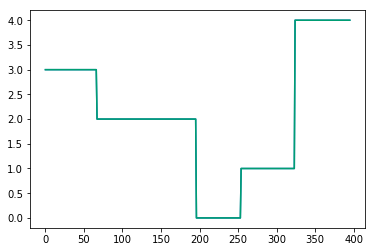

In [6]:
train_features, labels_idee = create_train(train_name, window_length, recouvrement, n, liste_labels, liste_transitions)
classifier1, classifier2, pca, scaler = build_model(train_features, labels_idee)
prediction_train = actually_predict(classifier1, classifier2, train_features, pca, scaler)
print('Prediction sur le train, juste pour voir : ')
plt.figure()
plt.plot(np.rint(prediction_train))
plt.plot(labels_idee)
plt.show()

Prediction sur le test : 


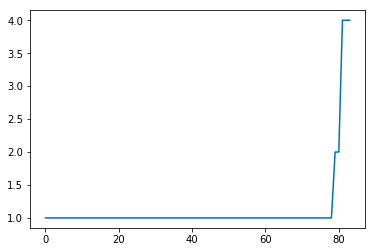

Prediction lissée sur le test


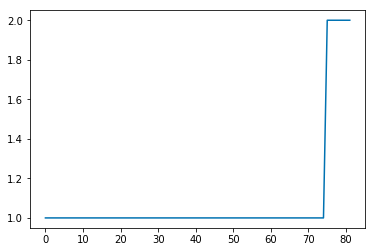

In [7]:
test_name = 'standpocket2.csv'
test_features = create_test(test_name, window_length, recouvrement, n)

print('Prediction sur le test : ')
prediction_test = actually_predict(classifier1, classifier2, test_features, pca, scaler)
plt.figure()
plt.plot(np.rint(prediction_test))
plt.show()


m = 10. # "lissage" de la solution
prediction = np.array(signal.convolve(prediction_test, np.ones(int(m))/m))
prediction = np.rint(prediction[math.ceil((m - 1)/ 2) + 1 : - math.floor((m - 1)/2) - 1])

print('Prediction lissée sur le test')
plt.figure()
plt.plot(prediction)
plt.show()

## Mise en forme des résultats

In [8]:
print('Prédiction :')
etat_courant = prediction[0]
temps = 0.002 * window_length * (1 - recouvrement)
for etat in prediction:
    if etat == etat_courant:
        temps = temps + 0.01 * window_length * (1 - recouvrement)
    else:
        print('On est resté dans l etat ', etat_courant, ' pendant ', temps, ' secondes')
        temps = 0.002 * window_length
        etat_courant = etat
print('On est resté dans l etat ', etat_courant, ' pendant ', temps, ' secondes')
# print(prediction)

Prédiction :
On est resté dans l etat  1.0  pendant  56.4  secondes
On est resté dans l etat  2.0  pendant  4.7  secondes
